In [1]:
# Project # 1 Jupyter Notebook
# Created by Melinda Eudy, Cameron Farquhar, Markita Francis, Luis Rojas, Kelly Rose.
# Project: 2017 Crime Data Used from several resources, UCR Crime Rates by County, US Census, and.......

In [2]:
# Dependencies and Setup *******Review before final presentation and remove what is not needed ************
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import scipy.stats as st
from datetime import date
from functools import reduce
import json
import ctypes

# Import API key
#from config import apikey

In [3]:
# Part 1 - open UCR Crime Rates by County.csv file
#----------open 37059-Codebook County Codes.csv file and merge into first file to obtain County Names
UCR_Crime = "Resources/UCR_Crime_Rate_by_County.csv"

# Read file and store in Pandas data frame\n",
UCR_Crime_df = pd.read_csv(UCR_Crime)
UCR_Crime_df.head()
#UCR_Crime_df.count() ----all columns had same count

,FIPS_ST,FIPS_CTY,population,crime_rate_per_100000,index,EDITION,PART,IDNO,CPOPARST,CPOPCRIM,...,INDEX,MODINDX,MURDER,RAPE,ROBBERY,AGASSLT,BURGLRY,LARCENY,MVTHEFT,ARSON
0,29,510,318416,1791.995377,1,1,4,1612,318667,318667,...,5706,22329,119,200,1778,3609,4995,13791,3543,464
1,5,35,49746,1754.914968,2,1,4,130,50717,50717,...,873,3424,8,38,165,662,1482,1753,189,28
2,17,3,7629,1664.700485,3,1,4,604,8040,8040,...,127,278,1,2,5,119,82,184,12,2
3,48,261,412,1456.310680,4,1,4,2681,444,444,...,6,13,0,3,1,2,5,4,4,0
4,22,31,27083,1447.402430,5,1,4,1137,26971,26971,...,392,703,3,4,17,368,149,494,60,0


In [4]:
# FIPS-ST is the first number of the Code, FIPS_City is the last three numbers of the code.
#-----Make FIPS_City three digits wide (adding zeros in front) and combine the two columns
UCR_Crime_df["FIPS_ST"] = UCR_Crime_df["FIPS_ST"].apply(str)
UCR_Crime_df["FIPS_CTY"] = UCR_Crime_df["FIPS_CTY"].apply(str)
UCR_Crime_df["FIPS_CTY"] = UCR_Crime_df["FIPS_CTY"].apply(lambda x: x.zfill(3))
UCR_Crime_df["CODE"] = UCR_Crime_df[["FIPS_ST", "FIPS_CTY"]].agg("".join, axis=1)
UCR_Crime_df.head()

,FIPS_ST,FIPS_CTY,population,crime_rate_per_100000,index,EDITION,PART,IDNO,CPOPARST,CPOPCRIM,...,MODINDX,MURDER,RAPE,ROBBERY,AGASSLT,BURGLRY,LARCENY,MVTHEFT,ARSON,CODE
0,29,510,318416,1791.995377,1,1,4,1612,318667,318667,...,22329,119,200,1778,3609,4995,13791,3543,464,29510
1,5,035,49746,1754.914968,2,1,4,130,50717,50717,...,3424,8,38,165,662,1482,1753,189,28,5035
2,17,003,7629,1664.700485,3,1,4,604,8040,8040,...,278,1,2,5,119,82,184,12,2,17003
3,48,261,412,1456.310680,4,1,4,2681,444,444,...,13,0,3,1,2,5,4,4,0,48261
4,22,031,27083,1447.402430,5,1,4,1137,26971,26971,...,703,3,4,17,368,149,494,60,0,22031


In [5]:
# Finalize file for merging
#-----remove columns: STUDYNO, EDITION, PART, FLIPS_ST, FLIPS_CTY
#-----move Code to the front of the file - ensure that it is a int64.
UCR_Crime_df.drop(columns = ["index", "EDITION", "PART", "FIPS_ST", "FIPS_CTY", "MODINDX", "INDEX", "COVIND"], inplace = True)
UCR_Crime_df["CODE"] = UCR_Crime_df["CODE"].apply("int64")
pd.set_option("precision",0)
collist = UCR_Crime_df.columns.tolist()
collist.insert(0, collist.pop(collist.index("CODE")))
UCR_Crime_df = UCR_Crime_df.reindex(columns = collist)

# Rename columns for better understanding\
UCR_Crime_df.rename(columns={"AG_ARRST": "# COUNTY AGENCY REPORTING ARREST", "AG_OFF": "# COUNTY AGENCY REPORTING CRIME"}, inplace = True)
UCR_Crime_df.rename(columns={"CPOPCRIM": "COUNTY POP - AGENCY REPORTING CRIME", "CPOPARST": "COUNTY POP - AGENCY REPORTING ARRESTS", "population": "POPULATION", "crime_rate_per_100000": "CRIME RATE PER 100k"}, inplace = True)
UCR_Crime_df.head()

,CODE,POPULATION,CRIME RATE PER 100k,IDNO,COUNTY POP - AGENCY REPORTING ARRESTS,COUNTY POP - AGENCY REPORTING CRIME,# COUNTY AGENCY REPORTING ARREST,# COUNTY AGENCY REPORTING CRIME,MURDER,RAPE,ROBBERY,AGASSLT,BURGLRY,LARCENY,MVTHEFT,ARSON
0,29510,318416,1792,1612,318667,318667,15,15,119,200,1778,3609,4995,13791,3543,464
1,5035,49746,1755,130,50717,50717,4,4,8,38,165,662,1482,1753,189,28
2,17003,7629,1665,604,8040,8040,2,2,1,2,5,119,82,184,12,2
3,48261,412,1456,2681,444,444,1,1,0,3,1,2,5,4,4,0
4,22031,27083,1447,1137,26971,26971,3,3,3,4,17,368,149,494,60,0


In [6]:
# Part 2: Open up code book for State and County
# -----merge this data into the Crime data frame
UCR_Codes = "Resources/Codebook_County_Codes.csv"

# Read file and store in Pandas data frame
UCR_Codes_df = pd.read_csv(UCR_Codes)
#UCR_Codes_df.count()   --- all columns had the same count

# Before mergining data:
# ------Remove Unnamed:3 - Unnamed:5
# ------Remove decimal in Code
#-------Rename Code to CODE\n",
UCR_Codes_df.drop(columns = ["Unnamed: 3", "Unnamed: 4", "Unnamed: 5"], inplace = True)
UCR_Codes_df.rename(columns={"Code":"CODE", "State":"STATE", "County":"COUNTY"}, inplace = True)
UCR_Codes_df["CODE"] = UCR_Codes_df["CODE"].apply("int64")
pd.set_option("precision",0)
UCR_Codes_df.head()

,STATE,CODE,COUNTY
0,Alabama,1001,Autauga
1,Alabama,1003,Baldwin
2,Alabama,1005,Barbour
3,Alabama,1007,Bibb
4,Alabama,1009,Blount


In [7]:
# Merge Codebook_County_Codes.csv into UCR_Crime_Rates_by_County.csv
merged_UCR_Crime_df = pd.merge(UCR_Codes_df, UCR_Crime_df,on="CODE")
merged_UCR_Crime_df.head(15)
#merged_UCR_Crime_df.dtypes

,STATE,CODE,COUNTY,POPULATION,CRIME RATE PER 100k,IDNO,COUNTY POP - AGENCY REPORTING ARRESTS,COUNTY POP - AGENCY REPORTING CRIME,# COUNTY AGENCY REPORTING ARREST,# COUNTY AGENCY REPORTING CRIME,MURDER,RAPE,ROBBERY,AGASSLT,BURGLRY,LARCENY,MVTHEFT,ARSON
0,Alabama,1001,Autauga,55246,252,1,57161,54604,3,3,3,15,34,87,447,1233,85,108
1,Alabama,1003,Baldwin,195540,228,2,187467,187467,14,14,8,30,76,332,967,3829,192,31
2,Alabama,1005,Barbour,27076,177,3,27228,25566,6,4,0,4,8,36,90,362,21,0
3,Alabama,1007,Bibb,22512,218,4,22907,22857,5,6,1,4,8,36,122,251,27,0
4,Alabama,1009,Blount,57872,211,5,57909,57909,6,6,1,11,9,101,397,865,86,9
5,Alabama,1011,Bullock,10639,526,6,10584,10584,2,2,0,2,12,43,98,55,3,23
6,Alabama,1013,Butler,20265,538,7,20741,20733,4,4,6,5,11,87,182,408,30,3
7,Alabama,1015,Calhoun,116736,581,8,122213,118270,8,10,6,37,131,504,1710,3482,147,34
8,Alabama,1017,Chambers,34162,562,9,34075,34075,4,4,1,7,24,160,374,875,96,5
9,Alabama,1019,Cherokee,26203,416,10,26141,26162,4,5,1,4,2,102,329,610,75,12


In [8]:
# Part 3: Bring in data from the US census per county
# -------adding median income per county
response = requests.get("https://api.census.gov/data/2017/acs/acs1?get=NAME,B06011_001E&for=county:*").json()
                        
# locate the first row and make it the column name and then drop row
income_df = pd.DataFrame(response)
income_df.columns = income_df.iloc[0]
income_df = income_df.drop([1])
    
# delete and null info and reset the index
income_df = income_df.dropna(how='any')
income_df.reset_index()
    
#replace the integer column names with values in row 0
income_df.columns = income_df.iloc[0]
income_df = income_df.drop([0])
income_df.reset_index()
income_df.head()
#income_df.dtypes"

,NAME,B06011_001E,state,county
2,"Calhoun County, Alabama",26121,01,015
3,"Cullman County, Alabama",22692,01,043
4,"DeKalb County, Alabama",21581,01,049
5,"Elmore County, Alabama",28967,01,051
6,"Etowah County, Alabama",19861,01,055


In [9]:
# create new columns for County and State
# ----Remove Columns: NAME, state, county
#-----Change column names to match merged UCR Crime data
#-----Remove word "County" in County name
income_df['County Name'] = income_df['NAME'].str.split(', ').apply(lambda x: x[0])
income_df['State Name'] = income_df['NAME'].str.split(', ').apply(lambda x: x[-1])
income_df['County Name'] = income_df['NAME'].str.split(' ').apply(lambda x: x[0])
income_df.drop(columns = ["NAME", "state", "county"], inplace = True)
income_df.rename(columns={"County Name":"COUNTY", "State Name":"STATE", "B06011_001E":"MEDIAN INCOME"}, inplace = True)
                          
# Clean up formating in Median Income
income_df["MEDIAN INCOME"] = income_df["MEDIAN INCOME"].apply("int64")
income_df.head()
#income_df.dtypes

,MEDIAN INCOME,COUNTY,STATE
2,26121,Calhoun,Alabama
3,22692,Cullman,Alabama
4,21581,DeKalb,Alabama
5,28967,Elmore,Alabama
6,19861,Etowah,Alabama


In [10]:
# Merge Census Median Income into UCR_Crime_Rates_by_County.csv\n",
# Move Median Income to front of chart\n",
Crime_df = pd.merge(merged_UCR_Crime_df, income_df, on=["STATE", "COUNTY"], how="left" )
collist = Crime_df.columns.tolist()
collist.insert(4, collist.pop(collist.index("MEDIAN INCOME")))
Crime_df = Crime_df.reindex(columns = collist)
    
# delete and null info and reset theindex
Crime_df = Crime_df.dropna(how='any')
Crime_df.head()

,STATE,CODE,COUNTY,POPULATION,MEDIAN INCOME,CRIME RATE PER 100k,IDNO,COUNTY POP - AGENCY REPORTING ARRESTS,COUNTY POP - AGENCY REPORTING CRIME,# COUNTY AGENCY REPORTING ARREST,# COUNTY AGENCY REPORTING CRIME,MURDER,RAPE,ROBBERY,AGASSLT,BURGLRY,LARCENY,MVTHEFT,ARSON
7,Alabama,1015,Calhoun,116736,26121,581,8,122213,118270,8,10,6,37,131,504,1710,3482,147,34
21,Alabama,1043,Cullman,80811,22692,238,22,80832,80859,3,4,2,16,13,161,483,1483,99,6
25,Alabama,1051,Elmore,80902,28967,284,26,80528,80484,7,8,4,23,44,159,665,1367,85,14
27,Alabama,1055,Etowah,103931,19861,514,28,103809,97544,10,8,2,45,126,361,1241,2674,294,42
34,Alabama,1069,Houston,103668,25153,401,35,103678,102780,9,9,7,42,108,259,1095,2380,184,18


In [11]:
# Part 3b: Bring in data from the US census per county
#------population density per county
response = requests.get(f"https://api.census.gov/data/2017/pep/population?get=DENSITY,POP,STATE&for=county:*").json()

# locate the first row and make it the column name and then drop row
county_dens_df = pd.DataFrame(response)
county_dens_df.columns = county_dens_df.iloc[0]
county_dens_df = county_dens_df.drop([0])
    
county_dens_df["state"] = county_dens_df["state"].apply(str)
county_dens_df["county"] = county_dens_df["county"].apply(str)
county_dens_df["county"] = county_dens_df["county"].apply(lambda x: x.zfill(3))
county_dens_df["CODE"] = county_dens_df[["state", "county"]].agg("".join, axis=1)

# delete and null info and reset the index
county_dens_df = county_dens_df.dropna(how='any')
county_dens_df.head()

,DENSITY,POP,STATE,state,county,CODE
1,14.666355113,12469,01,01,035,01035
2,16.521468381,10754,01,01,037,01037
3,35.995681469,37092,01,01,039,01039
4,22.781736369,13871,01,01,041,01041
5,112.62558771,82755,01,01,043,01043


In [12]:
#-----Remove column names to match merged UCR Crime data
county_dens_df.drop(columns = ["STATE", "state", "county"], inplace = True)
county_dens_df["POP"] = county_dens_df["POP"].apply("int64")
county_dens_df["CODE"] = county_dens_df["CODE"].apply("int64")
county_dens_df["DENSITY"] = county_dens_df["DENSITY"].apply(lambda x: float(x))
county_dens_df["DENSITY"] = round(county_dens_df["DENSITY"],2)
county_dens_df.head()

,DENSITY,POP,CODE
1,15,12469,1035
2,17,10754,1037
3,36,37092,1039
4,23,13871,1041
5,113,82755,1043


In [13]:
# Merge Codebook_County_Codes.csv into UCR_Crime_Rates_by_County.csv
# Move Density and Population to front of chart
merged_Crime_df = pd.merge(Crime_df, county_dens_df, on=["CODE"], how = "right")
collist = merged_Crime_df.columns.tolist()
collist.insert(4, collist.pop(collist.index("DENSITY")))
collist.insert(5, collist.pop(collist.index("POP")))
merged_Crime_df = merged_Crime_df.reindex(columns = collist)

# delete and null info and reset the index
merged_Crime_df = merged_Crime_df.dropna(how='any')
merged_Crime_df.reset_index()
merged_Crime_df.head()
#merged_Crime_df.dtypes

,STATE,CODE,COUNTY,POPULATION,DENSITY,POP,MEDIAN INCOME,CRIME RATE PER 100k,IDNO,COUNTY POP - AGENCY REPORTING ARRESTS,...,# COUNTY AGENCY REPORTING ARREST,# COUNTY AGENCY REPORTING CRIME,MURDER,RAPE,ROBBERY,AGASSLT,BURGLRY,LARCENY,MVTHEFT,ARSON
0,Alabama,1015,Calhoun,116736,189,114728,26121,581,8,122213,...,8,10,6,37,131,504,1710,3482,147,34
1,Alabama,1043,Cullman,80811,113,82755,22692,238,22,80832,...,3,4,2,16,13,161,483,1483,99,6
2,Alabama,1051,Elmore,80902,132,81677,28967,284,26,80528,...,7,8,4,23,44,159,665,1367,85,14
3,Alabama,1055,Etowah,103931,192,102755,19861,514,28,103809,...,10,8,2,45,126,361,1241,2674,294,42
4,Alabama,1069,Houston,103668,180,104346,25153,401,35,103678,...,9,9,7,42,108,259,1095,2380,184,18


In [14]:
# Part 4a: Bring in FBI data file with age of offenders in the counties.
#----------open agency_crimes_stat.csv file and merge with agencies.csv to get counties
# ---------merge with merged_Crime and rename as Final_Crime_Database_df
Age_County = "output_data/agency_crimes_stat.csv"

# Read file, remove unneeded columns, remove NA information and store in Pandas data frame
Age_County_df = pd.read_csv(Age_County)
Age_County_df.drop(columns = ["year", "agency"], inplace = True)
Age_County_df = Age_County_df.dropna(how='any')
Age_County_df.reset_index()
Age_County_df.head()

,crime_type,agency_name,county,state,state_name,latitude,longitude,age 0-9,age 10-19,age 20-29,age 30-39,age 40-49,age 50-59,age 60-69,age 70-79,age 80-89,age 90-Older,age Unknown,total_crimes
0,property-crime,Milford Police Department,KENT; SUSSEX,DE,Delaware,39,-75,2,73,151,89,67,47,6,2,0,0,113,550
1,violent-crime,Milford Police Department,KENT; SUSSEX,DE,Delaware,39,-75,2,32,30,14,4,3,0,0,0,0,20,105
2,property-crime,Laurel Police Department,SUSSEX,DE,Delaware,39,-75,1,27,58,24,9,5,1,3,1,0,42,171
3,violent-crime,Laurel Police Department,SUSSEX,DE,Delaware,39,-75,0,24,22,9,4,1,0,0,0,0,6,66
5,property-crime,Bridgeville Police Department,SUSSEX,DE,Delaware,39,-76,0,0,5,5,3,1,0,0,0,0,18,32


In [15]:
# Part 4b: Bring in FBI data file with age of offenders in the counties.
#----------open agency_crimes_stat.csv file and merge with agencies.csv to get counties
# ---------merge with merged_Crime and rename as Final_Crime_Database_df
Agency_County = "output_data/agencies.csv"

# Read file, remove unneeded columns, remove NA information and store in Pandas data frame
Agency_County_df = pd.read_csv(Agency_County)
Agency_County_df.drop(columns = ["ori", "agency_name", "state_abbr", "division_name", "region_name", "region_desc", "nibrs", "nibrs_start_date"], inplace = True)
Agency_County_df = Agency_County_df[(Agency_County_df["agency_type_name"] == "County")]
Agency_County_df = Agency_County_df.dropna(how='any')
Agency_County_df.reset_index()
Agency_County_df.head()
#Agency_County_df.dtypes

,agency_type_name,state_name,county_name,latitude,longitude
0,County,Hawaii,HAWAII,20,-155
1,County,Hawaii,MAUI,21,-156
3,County,Hawaii,KAUAI,22,-160
17,County,Delaware,NEW CASTLE,40,-76
67,County,Texas,WASHINGTON,30,-96


In [16]:
# Merge agencies.csv and age offenders by county together
merged_Age_County_df = pd.merge(Agency_County_df, Age_County_df, on=["latitude", "longitude"], how = "right")

# delete and null info and reset the index
merged_Age_County_df = merged_Age_County_df.dropna(how='any')
merged_Age_County_df.reset_index()
merged_Age_County_df.head()
#merged_Age_County_df.dtypes

,agency_type_name,state_name_x,county_name,latitude,longitude,crime_type,agency_name,county,state,state_name_y,...,age 20-29,age 30-39,age 40-49,age 50-59,age 60-69,age 70-79,age 80-89,age 90-Older,age Unknown,total_crimes
0,County,Delaware,NEW CASTLE,40,-76,property-crime,New Castle County Police Department,NEW CASTLE,DE,Delaware,...,625,428,185,50,9,0,0,0,733,2612
1,County,Delaware,NEW CASTLE,40,-76,violent-crime,New Castle County Police Department,NEW CASTLE,DE,Delaware,...,281,152,77,62,8,2,0,0,158,951
2,County,Texas,JACKSON,29,-97,property-crime,Jackson County Sheriff's Office,JACKSON,TX,Texas,...,6,6,1,1,2,0,0,0,1,20
3,County,Texas,JACKSON,29,-97,violent-crime,Jackson County Sheriff's Office,JACKSON,TX,Texas,...,1,2,1,0,0,0,0,0,1,8
4,County,Texas,BREWSTER,29,-95,property-crime,Brewster County Sheriff's Office,BREWSTER,TX,Texas,...,2,4,1,1,2,0,0,0,0,11


In [17]:
# Clean up file to merge into merged_Crime_df
#----------remove columns: agnecy_type_name, state, state_name_x
#----------rename columns: county_name, latitude, longitude, crime_type, agency_name, county, state_name
merged_Age_County_df.drop(columns = ["agency_type_name", "state_name_x", "state", "county", "age Unknown"], inplace = True)
merged_Age_County_df.rename(columns={"county_name": "COUNTY", "total_crimes": "TOTAL CRIMES", "crime_type": "CRIME TYPE", "state_name_y": "STATE", "county":"COUNTY", "agency_name":"AGENCY","latitude": "LATITUDE", "longitude": "LONGITUDE" }, inplace = True)
merged_Age_County_df["COUNTY"] = merged_Age_County_df["COUNTY"].str.lower()
merged_Age_County_df["COUNTY"] = merged_Age_County_df["COUNTY"].str.title()
merged_Age_County_df.head()
#merged_Age_County_df.dtypes

,COUNTY,LATITUDE,LONGITUDE,CRIME TYPE,AGENCY,STATE,age 0-9,age 10-19,age 20-29,age 30-39,age 40-49,age 50-59,age 60-69,age 70-79,age 80-89,age 90-Older,TOTAL CRIMES
0,New Castle,40,-76,property-crime,New Castle County Police Department,Delaware,10,572,625,428,185,50,9,0,0,0,2612
1,New Castle,40,-76,violent-crime,New Castle County Police Department,Delaware,3,208,281,152,77,62,8,2,0,0,951
2,Jackson,29,-97,property-crime,Jackson County Sheriff's Office,Texas,0,3,6,6,1,1,2,0,0,0,20
3,Jackson,29,-97,violent-crime,Jackson County Sheriff's Office,Texas,0,3,1,2,1,0,0,0,0,0,8
4,Brewster,29,-95,property-crime,Brewster County Sheriff's Office,Texas,0,1,2,4,1,1,2,0,0,0,11


In [18]:
# FINAL CRIME STATES: merge_Age_County_df and merged_Crime_df
#----------Rearrange columns to make sense
Final_Crime_df = pd.merge(merged_Crime_df, merged_Age_County_df, on=["STATE", "COUNTY"])

#collist = Final_Crime_df.columns.tolist()
#collist
Column_Order = ["STATE", "CODE", "COUNTY", "POPULATION", "DENSITY", "MEDIAN INCOME", "CRIME RATE PER 100k", "COUNTY POP - AGENCY REPORTING ARRESTS", "COUNTY POP - AGENCY REPORTING CRIME", "# COUNTY AGENCY REPORTING ARREST"," # COUNTY AGENCY REPORTING CRIME", "TOTAL CRIMES", "IDNO", "age 0-9", "age 10-19", "age 20-29", "age 30-39", "age 40-49", "age 50-59", "age 60-69", "age 70-79", "age 80-89", "age 90-Older", "AGE ", "MURDER", "RAPE", "ROBBERY", "AGASSLT", "BURGLRY", "LARCENY", "MVTHEFT", "ARSON", "LATITUDE", "LONGITUDE", "POP"]
Final_Crime_df = Final_Crime_df.reindex(columns=Column_Order)

Final_Crime_df["POPULATION"] = Final_Crime_df["POPULATION"].apply("int64")
Final_Crime_df["COUNTY POP - AGENCY REPORTING ARRESTS"] = Final_Crime_df["COUNTY POP - AGENCY REPORTING ARRESTS"].apply("int64")
Final_Crime_df["COUNTY POP - AGENCY REPORTING CRIME"] = Final_Crime_df["COUNTY POP - AGENCY REPORTING CRIME"].apply("int64")

#delete and null info and reset the index
#Violent_Crime_df = Violent_Crime_df.dropna(how='any')
#Violent_Crime_df.reset_index()

# Output File (CSV)
output_data_file = "output_data/Final_Crime.csv"

# Export file as a CSV
Final_Crime_df.to_csv(output_data_file, index=False, header=True)

Final_Crime_df.head()

,STATE,CODE,COUNTY,POPULATION,DENSITY,MEDIAN INCOME,CRIME RATE PER 100k,COUNTY POP - AGENCY REPORTING ARRESTS,COUNTY POP - AGENCY REPORTING CRIME,# COUNTY AGENCY REPORTING ARREST,...,RAPE,ROBBERY,AGASSLT,BURGLRY,LARCENY,MVTHEFT,ARSON,LATITUDE,LONGITUDE,POP
0,Arizona,4027,Yuma,201201,38,23290,346,203062,200100,6,...,41,72,576,1567,3078,394,45,33,-115,207534
1,Arizona,4027,Yuma,201201,38,23290,346,203062,200100,6,...,41,72,576,1567,3078,394,45,33,-115,207534
2,Arkansas,5007,Benton,237297,314,32114,267,222170,228420,15,...,112,29,490,1214,3461,176,22,36,-94,266300
3,Arkansas,5007,Benton,237297,314,32114,267,222170,228420,15,...,112,29,490,1214,3461,176,22,36,-94,266300
4,Arkansas,5007,Benton,237297,314,32114,267,222170,228420,15,...,112,29,490,1214,3461,176,22,36,-94,266300


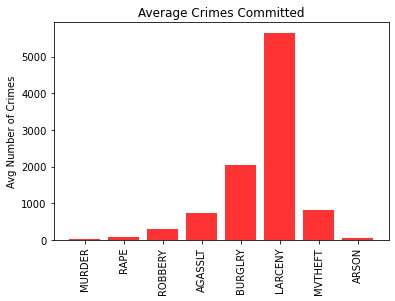

In [19]:
crimes_type = Final_Crime_df[['MURDER', 'RAPE', 'ROBBERY','AGASSLT', 'BURGLRY', 'LARCENY', 'MVTHEFT', 'ARSON']].mean()
x_axis = np.arange(len(crimes_type))
plt.bar(x_axis, crimes_type, color='r', alpha=0.8, align="center")
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, ['MURDER', 'RAPE', 'ROBBERY','AGASSLT', 'BURGLRY', 'LARCENY', 'MVTHEFT', 'ARSON'],rotation = 90)

plt.title("Average Crimes Committed")
# plt.xlabel("Crimes")
plt.ylabel("Avg Number of Crimes")

plt.show()

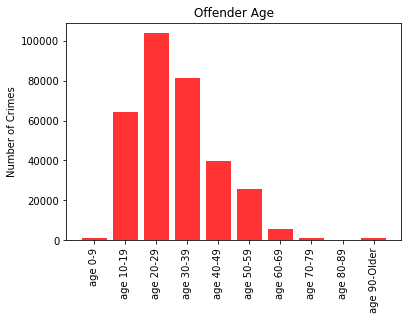

In [27]:
crimes_age = Final_Crime_df[['age 0-9', 'age 10-19', 'age 20-29',
       'age 30-39', 'age 40-49', 'age 50-59', 'age 60-69', 'age 70-79',
       'age 80-89', 'age 90-Older']].sum()
x_axis = np.arange(len(crimes_age))
plt.bar(x_axis, crimes_age, color='r', alpha=0.8, align="center")
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, ['age 0-9', 'age 10-19', 'age 20-29',
       'age 30-39', 'age 40-49', 'age 50-59', 'age 60-69', 'age 70-79',
       'age 80-89', 'age 90-Older'],rotation = 90)

plt.title("Offender Age")
# plt.xlabel("Crimes")
plt.ylabel("Number of Crimes")

plt.show()

In [56]:
print(Final_Crime_df['MEDIAN INCOME'].max())
print(Final_Crime_df['MEDIAN INCOME'].min())

66404.0
16246.0


In [79]:
bins = [0, 5999, 11999, 17999, 23999, 29999,
        35999, 41999, 47999, 53999, 59999]

group_labels = ["0 to $6k", "$6k to $12k", "$12k to $18k", "$18k to $24k", "$24k to $30k", "$30k to $36k",
                "$42k to $48k", "$48k to $54k", "$54k to $60k", "$60k and up"]

Final_Crime_df["Income Bin"] = pd.cut(Final_Crime_df['MEDIAN INCOME'], bins, labels=group_labels)

income_counts = Final_Crime_df["Income Bin"].value_counts()

# plt.bar(group_labels,income_counts)
# plt.show()

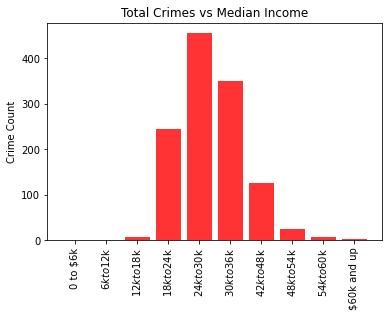

In [91]:
income_group = Final_Crime_df.groupby(["Income Bin"])
crime_group = income_group["TOTAL CRIMES"].count()

x_axis = np.arange(len(rob_group))
plt.bar(x_axis, crime_group, color='r', alpha=0.8, align="center")
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, ["0 to $6k", "$6k to $12k", "$12k to $18k", "$18k to $24k", "$24k to $30k", "$30k to $36k",
                "$42k to $48k", "$48k to $54k", "$54k to $60k", "$60k and up"],rotation = 90)

plt.title("Total Crimes vs Median Income")
# plt.xlabel("Crimes")
plt.ylabel("Crime Count")

plt.show()

In [93]:
Final_Crime_df.columns

Index(['STATE', 'CODE', 'COUNTY', 'POPULATION', 'DENSITY', 'MEDIAN INCOME',
       'CRIME RATE PER 100k', 'COUNTY POP - AGENCY REPORTING ARRESTS',
       'COUNTY POP - AGENCY REPORTING CRIME',
       '# COUNTY AGENCY REPORTING ARREST', ' # COUNTY AGENCY REPORTING CRIME',
       'TOTAL CRIMES', 'IDNO', 'age 0-9', 'age 10-19', 'age 20-29',
       'age 30-39', 'age 40-49', 'age 50-59', 'age 60-69', 'age 70-79',
       'age 80-89', 'age 90-Older', 'AGE ', 'MURDER', 'RAPE', 'ROBBERY',
       'AGASSLT', 'BURGLRY', 'LARCENY', 'MVTHEFT', 'ARSON', 'LATITUDE',
       'LONGITUDE', 'POP', 'Income Bin'],
      dtype='object')

the r-value is: 0.05647980388617638
The correlation coefficient 0.06


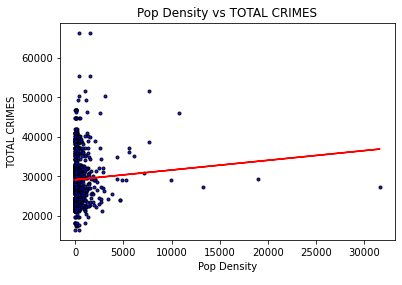

In [101]:
x_values = Final_Crime_df["TOTAL CRIMES"]
y_values = Final_Crime_df["MEDIAN INCOME"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values, y_values, marker=".", facecolors="blue", edgecolors="black", alpha=0.90)

plt.plot(x_values,regress_values,"r-")

plt.annotate(line_eq,(0, 5000), fontsize=15,color="red")

plt.title("Pop Density vs TOTAL CRIMES")
plt.xlabel("Pop Density")
plt.ylabel("TOTAL CRIMES")

# plt.xlim(0, 2000)
# plt.ylim(0, 6000)

print(f'the r-value is: {rvalue}')
print(f'The correlation coefficient {round(st.pearsonr(x_values,y_values)[0],2)}')